### Mixture of Experts (MoE) Transformer with Llama4 type model 

Author: Tirth Shah  
Inspired by: https://github.com/FareedKhan-dev/train-llama4

#### Import Required Libraries and Modules

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Import our custom modules
from model import MoETransformer, ModelConfig
from prepare_data import CharDataset, TinyStoriesDataset, sample_alice_text
from train import TrainModel, TrainConfig
import utils as utils

/home/tirth/miniforge-pypy3/envs/moe-experiments/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Set random seed for reproducibility

In [2]:
torch.manual_seed(42)

#### Prepare Dataset

In [3]:
dataset_tag = 'sample_alice'  # Choose dataset: 'sample_alice' or 'tiny_stories'

if dataset_tag == 'sample_alice':
    #--------- Sample text from Alice's Adventures in Wonderland ---------#
    # This is a small excerpt to keep the dataset manageable for demonstration purposes.

    block_size = 64 # Define the block size for the dataset
    dataset = CharDataset(text=sample_alice_text, block_size=block_size) # Create dataset

elif dataset_tag == 'tiny_stories':
    #--------- Tiny stories dataset ---------#
    # This dataset is a collection of short stories, which can be used for training language models.

    block_size = 64 # Define the block size for the dataset
    dataset = TinyStoriesDataset(block_size=block_size, max_samples=100000)  # Load the dataset

else:
    raise ValueError("Invalid dataset_tag. Choose 'sample_alice' or 'tiny_stories'.")

#### Initialize MoE Transformer Model

In [4]:
# Model configuration
model_config = ModelConfig(
    dataset_tag=dataset_tag,
    d_model=128, 
    n_layers=5, # 5
    n_heads=4,
    block_size=block_size,
    vocab_size=dataset.tokenizer.vocab_size,
    rms_norm_eps=1e-5,
    rope_theta=10000.0,
    num_local_experts=4,
    num_experts_per_tok=2, # 1, 2
    intermediate_size_expert=256,
    intermediate_size_shared=256,
    random_routing=True,
)

# Initialize the model
model = MoETransformer(config=model_config)
model = model.to(model.config.device)

# Print model summary
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model initialized successfully!")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Model initialized successfully!
Total parameters: 2,795,264
Trainable parameters: 2,795,264


#### Train the Model

Setting up training configuration

In [5]:
train_config = TrainConfig(
    learning_rate=1e-3,
    batch_size=16,
    steps=3000, # Set to 3000 for actual training
    print_interval=300,
    test_split=0.1
)

train_model = TrainModel(
    train_config=train_config,
    model=model,
    dataset=dataset,
)

Training the model

Starting training...


 10%|█         | 303/3000 [00:18<02:39, 16.93it/s]

Step 300/3000, Loss: 0.0920


 20%|██        | 603/3000 [00:35<02:21, 16.90it/s]

Step 600/3000, Loss: 0.0741


 30%|███       | 903/3000 [00:53<02:04, 16.80it/s]

Step 900/3000, Loss: 0.0676


 40%|████      | 1203/3000 [01:11<01:46, 16.83it/s]

Step 1200/3000, Loss: 0.0654


 50%|█████     | 1503/3000 [01:29<01:29, 16.78it/s]

Step 1500/3000, Loss: 0.0672


 60%|██████    | 1803/3000 [01:47<01:11, 16.83it/s]

Step 1800/3000, Loss: 0.0750


 70%|███████   | 2103/3000 [02:05<00:53, 16.80it/s]

Step 2100/3000, Loss: 0.0672


 80%|████████  | 2403/3000 [02:22<00:35, 16.80it/s]

Step 2400/3000, Loss: 0.0717


 90%|█████████ | 2703/3000 [02:40<00:17, 16.80it/s]

Step 2700/3000, Loss: 0.0616


100%|██████████| 3000/3000 [02:58<00:00, 16.81it/s]


Step 3000/3000, Loss: 0.0648


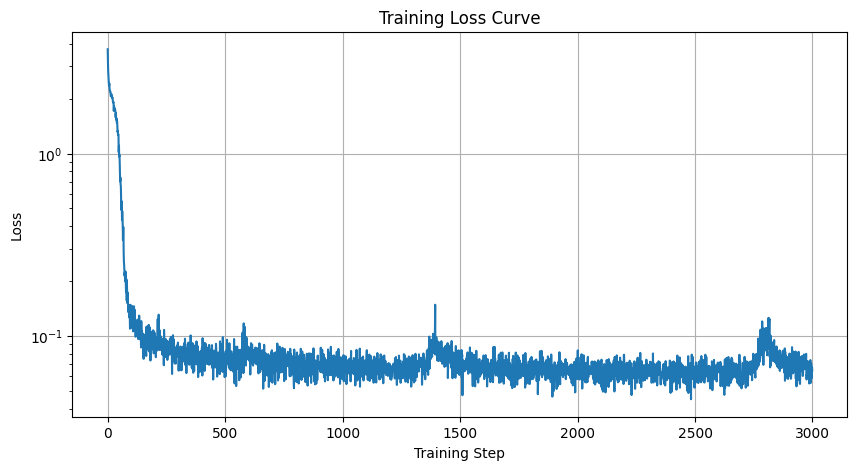

Training completed.
Final training loss: 0.0648


In [6]:
train_model.train()

print(f"Final training loss: {train_model.train_losses[-1]:.4f}")

Calculating test loss

In [7]:
test_loss = train_model.test_loss()

print(f"Test loss: {test_loss:.4f}")

Test loss: 0.1197


#### Save the Model

In [8]:
utils.save_model(
    train_obj=train_model,
    path=f"./saved_models/try_{dataset_tag}_random_routing_{model_config.random_routing}_top_{model_config.num_experts_per_tok}.pth",
    # path=f"./saved_models/try.pth",
)

Model saved to ./saved_models/try_sample_alice_random_routing_True_top_2.pth


#### Generate some text using the trained model

In [9]:
if dataset_tag == 'sample_alice':
    seed_text = "Alice likes"
elif dataset_tag == 'tiny_stories':
    seed_text = "Once upon a time"

model.generate(
    seed_text=seed_text,
    tokenizer=dataset.tokenizer,
    max_new_tokens=model_config.block_size,
)

Generation loop finished.


'Alice likesher could ing in wothe\n        book her sister was reading, but '